## Factorization Machine

In [22]:
import os
import csv
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import warnings
warnings.simplefilter('ignore')

class Config:
    category_col = ['user_id','movie_id','Action','Adventure','Animation',"Childrens",'Comedy','Crime',
          'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
          'Romance','Sci-Fi','Thriller','War','Western', 'gender','occupation','year']
    num_col = ['age']
    target_col = ['label']
    
    seed=2021
    epochs=5
    batch_size=128
    seed=17
    embedding_dim=8
    lr=1e-4
    
config=Config()

In [23]:
def load_data_df():
    df = pd.read_csv( 'ml-100k/u.data', sep='\t', header=None)
    df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
    return df

def load_item_df():
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
          'unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime',
          'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
          'Romance','Sci-Fi','Thriller','War','Western',]
    item_df = pd.read_csv(os.path.join('ml-100k/u.item'), sep='|', encoding="iso-8859-1", names=m_cols)
    item_df = item_df.rename(columns={"Children's":'Childrens'})
    return item_df

def load_user_df():
    u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
    user_df = pd.read_csv(os.path.join('ml-100k/u.user'), sep='|', encoding="iso-8859-1", names=u_cols)
    return user_df

In [24]:
data_df = load_data_df()
item_df = load_item_df()
user_df = load_user_df()

In [25]:
data_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [26]:
 user_df.head()
    

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [27]:
item_df.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Preproc

In [28]:
def merge_df(data_df, item_df, user_df):
    tmp = pd.merge(data_df, user_df, on='user_id', how='inner')
    tmp = pd.merge(tmp, item_df, on='movie_id', how='inner')
    tmp = tmp
    return tmp

df = merge_df(data_df, item_df, user_df)
df

,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,3,889289491,17,M,student,60089,B. Monkey (1998),06-Feb-1998,...,0,0,0,0,0,1,0,1,0,0
99996,863,1678,1,889289570,17,M,student,60089,Mat' i syn (1997),06-Feb-1998,...,0,0,0,0,0,0,0,0,0,0
99997,863,1680,2,889289570,17,M,student,60089,Sliding Doors (1998),01-Jan-1998,...,0,0,0,0,0,1,0,0,0,0
99998,896,1681,3,887160722,28,M,writer,91505,You So Crazy (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,0,0


,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
1,305,242,5,886307828,23,M,programmer,94086,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
2,6,242,4,883268170,42,M,executive,98101,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
3,234,242,4,891033261,60,M,retired,94702,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
4,63,242,3,875747190,31,M,marketing,75240,Kolya (1996),24-Jan-1997,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,863,1679,3,889289491,17,M,student,60089,B. Monkey (1998),06-Feb-1998,...,0,0,0,0,0,1,0,1,0,0
99996,863,1678,1,889289570,17,M,student,60089,Mat' i syn (1997),06-Feb-1998,...,0,0,0,0,0,0,0,0,0,0
99997,863,1680,2,889289570,17,M,student,60089,Sliding Doors (1998),01-Jan-1998,...,0,0,0,0,0,1,0,0,0,0
99998,896,1681,3,887160722,28,M,writer,91505,You So Crazy (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,0,0


In [29]:


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


def build_preprocessor(config): 
    category_col = config.category_col
    num_col = config.num_col
    
    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std', (StandardScaler())),])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value='NAN')),
        ('oe', (OrdinalEncoder())),
        ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_col),
            ('cat', categorical_transformer, category_col),
        ],
        remainder="drop")
    return preprocessor
    
def preprocess(df, config):
    
    category_col = config.category_col
    num_col = config.num_col
    target_col = config.target_col
    
    # Only use movies with more than 10 views
    print(df.shape)
    movie_cnt = df.groupby('movie_id').size()
    use_movies = list(movie_cnt[movie_cnt > 10].index)
    df = df[df['movie_id'].isin(use_movies)]
    print(df.shape)

    # Extract release year.
    df["year"] = df['release_date'].apply(lambda x: str(x).split('-')[-1]) 

    # Create a label column for binary classification.
    df.insert(df.shape[1],target_col,df['rating']>=4.0,True)
    #df[target_col] = df['rating'] >= 4.0
    df[target_col] = df[target_col].astype(int)

    # Build pipeline
    pp = build_preprocessor(config)
    pp.fit(df)
    return df, pp



In [30]:
df, pp = preprocess(df, config)

(100000, 31)
(97623, 31)
(100000, 31)
(97623, 31)


In [31]:
pp.transform(df).shape

(97623, 24)

(97623, 24)

In [32]:
# split data
tra_df, val_df = train_test_split(df, test_size=0.2, stratify=df['movie_id'], random_state=config.seed)
print(tra_df.shape)
print(val_df.shape)

(78098, 33)
(19525, 33)
(78098, 33)
(19525, 33)


In [33]:
assert tra_df.movie_id.nunique() == val_df.movie_id.nunique()
assert len(set(val_df.user_id) - set(tra_df.user_id)) == 0

## Training

In [34]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, add, Activation, dot
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2 as l2_reg
import itertools
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

def build_model(category_num, category_cols, num_cols, K=8, solver='adam', l2=0.0, l2_fm=0.0):

    # Numerical features
    num_inputs = [Input(shape=(1,), name=col,) for col in num_cols]
    # Categorical features
    cat_inputs = [Input(shape=(1,), name=col,) for col in category_cols]

    inputs = num_inputs + cat_inputs

    flatten_layers=[]
    # Numerical featrue embedding
    for enc_inp, col in zip(num_inputs, num_cols):
        # num featrue dence
        x = Dense(K, name = f'embed_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_layers.append(x)

    # Category feature embedding
    for enc_inp, col in zip(cat_inputs, category_cols):
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=K,
                            input_length=1,
                            name=f'embed_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        flatten_layers.append(flatten_c)
                
    # Feature interaction term
    fm_layers = []
    for emb1,emb2 in itertools.combinations(flatten_layers, 2):
        dot_layer = dot([emb1,emb2], axes=1)
        fm_layers.append(dot_layer)
    #print(fm_layers)
        

    # Linear term
    for enc_inp,col in zip(cat_inputs, category_cols):
        # embedding
        num_c = category_num[col]
        embed_c = Embedding(input_dim=num_c,
                            output_dim=1,
                            input_length=1,
                            name=f'linear_{col}',
                            embeddings_regularizer=l2_reg(l2_fm))(enc_inp)
        flatten_c = Flatten()(embed_c)
        fm_layers.append(flatten_c)
                
    for enc_inp, col in zip(num_inputs, num_cols):
        x = Dense(1, name = f'linear_{col}',kernel_regularizer=l2_reg(l2_fm))(enc_inp)
        fm_layers.append(x)

    # Add all terms
    flatten = add(fm_layers)
    outputs = Activation('sigmoid',name='outputs')(flatten)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
                optimizer=solver,
                loss='binary_crossentropy',
                metrics='accuracy'
              )

    return model 

In [35]:
category_num = {col: df[col].nunique() for col in config.category_col}
model = build_model(category_num, config.category_col, config.num_col, K=config.embedding_dim)

In [36]:
model.summary()

Model: "model_1"
Model: "model_1"
__________________________________________________________________________________________________
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
                                                                                                  
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                           

 Western (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
                                                                                                  
 gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 occupation (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 occupation (InputLayer)        [(None, 1)]          0           []                               
          

                                                                                                  
 embed_Sci-Fi (Embedding)       (None, 1, 8)         16          ['Sci-Fi[0][0]']                 
                                                                                                  
 embed_Thriller (Embedding)     (None, 1, 8)         16          ['Thriller[0][0]']               
                                                                                                  
 embed_Thriller (Embedding)     (None, 1, 8)         16          ['Thriller[0][0]']               
                                                                                                  
 embed_War (Embedding)          (None, 1, 8)         16          ['War[0][0]']                    
                                                                                                  
                                                                                                  
 embed_War

 flatten_58 (Flatten)           (None, 8)            0           ['embed_Horror[0][0]']           
                                                                                                  
 flatten_59 (Flatten)           (None, 8)            0           ['embed_Musical[0][0]']          
                                                                                                  
 flatten_60 (Flatten)           (None, 8)            0           ['embed_Mystery[0][0]']          
                                                                                                  
 flatten_60 (Flatten)           (None, 8)            0           ['embed_Mystery[0][0]']          
                                                                                                  
                                                                                                  
 flatten_61 (Flatten)           (None, 8)            0           ['embed_Romance[0][0]']          
          

                                                                                                  
                                                                                                  
 linear_Film-Noir (Embedding)   (None, 1, 1)         2           ['Film-Noir[0][0]']              
 linear_Film-Noir (Embedding)   (None, 1, 1)         2           ['Film-Noir[0][0]']              
                                                                                                  
                                                                                                  
 linear_Horror (Embedding)      (None, 1, 1)         2           ['Horror[0][0]']                 
 linear_Horror (Embedding)      (None, 1, 1)         2           ['Horror[0][0]']                 
                                                                                                  
                                                                                                  
 linear_Mu

                                                                  'flatten_51[0][0]']             
                                                                                                  
                                                                                                  
 dot_282 (Dot)                  (None, 1)            0           ['embed_age[0][0]',              
 dot_282 (Dot)                  (None, 1)            0           ['embed_age[0][0]',              
                                                                  'flatten_52[0][0]']             
                                                                  'flatten_52[0][0]']             
                                                                                                  
                                                                                                  
 dot_283 (Dot)                  (None, 1)            0           ['embed_age[0][0]',              
 dot_283 (

                                                                  'flatten_65[0][0]']             
                                                                  'flatten_65[0][0]']             
                                                                                                  
                                                                                                  
 dot_296 (Dot)                  (None, 1)            0           ['embed_age[0][0]',              
 dot_296 (Dot)                  (None, 1)            0           ['embed_age[0][0]',              
                                                                  'flatten_66[0][0]']             
                                                                  'flatten_66[0][0]']             
                                                                                                  
                                                                                                  
 dot_297 (

 dot_309 (Dot)                  (None, 1)            0           ['flatten_46[0][0]',             
                                                                  'flatten_57[0][0]']             
                                                                  'flatten_57[0][0]']             
                                                                                                  
                                                                                                  
 dot_310 (Dot)                  (None, 1)            0           ['flatten_46[0][0]',             
 dot_310 (Dot)                  (None, 1)            0           ['flatten_46[0][0]',             
                                                                  'flatten_58[0][0]']             
                                                                  'flatten_58[0][0]']             
                                                                                                  
          

 dot_323 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
 dot_323 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
                                                                  'flatten_50[0][0]']             
                                                                  'flatten_50[0][0]']             
                                                                                                  
                                                                                                  
 dot_324 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
 dot_324 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
                                                                  'flatten_51[0][0]']             
                                                                  'flatten_51[0][0]']             
          

                                                                                                  
 dot_337 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
 dot_337 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
                                                                  'flatten_64[0][0]']             
                                                                  'flatten_64[0][0]']             
                                                                                                  
                                                                                                  
 dot_338 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
 dot_338 (Dot)                  (None, 1)            0           ['flatten_47[0][0]',             
                                                                  'flatten_65[0][0]']             
          

                                                                                                  
                                                                                                  
 dot_351 (Dot)                  (None, 1)            0           ['flatten_48[0][0]',             
 dot_351 (Dot)                  (None, 1)            0           ['flatten_48[0][0]',             
                                                                  'flatten_58[0][0]']             
                                                                  'flatten_58[0][0]']             
                                                                                                  
                                                                                                  
 dot_352 (Dot)                  (None, 1)            0           ['flatten_48[0][0]',             
 dot_352 (Dot)                  (None, 1)            0           ['flatten_48[0][0]',             
          

                                                                  'flatten_52[0][0]']             
                                                                                                  
                                                                                                  
 dot_365 (Dot)                  (None, 1)            0           ['flatten_49[0][0]',             
 dot_365 (Dot)                  (None, 1)            0           ['flatten_49[0][0]',             
                                                                  'flatten_53[0][0]']             
                                                                  'flatten_53[0][0]']             
                                                                                                  
                                                                                                  
 dot_366 (Dot)                  (None, 1)            0           ['flatten_49[0][0]',             
 dot_366 (

                                                                  'flatten_66[0][0]']             
                                                                  'flatten_66[0][0]']             
                                                                                                  
                                                                                                  
 dot_379 (Dot)                  (None, 1)            0           ['flatten_49[0][0]',             
 dot_379 (Dot)                  (None, 1)            0           ['flatten_49[0][0]',             
                                                                  'flatten_67[0][0]']             
                                                                  'flatten_67[0][0]']             
                                                                                                  
                                                                                                  
 dot_380 (

 dot_392 (Dot)                  (None, 1)            0           ['flatten_50[0][0]',             
                                                                  'flatten_62[0][0]']             
                                                                  'flatten_62[0][0]']             
                                                                                                  
                                                                                                  
 dot_393 (Dot)                  (None, 1)            0           ['flatten_50[0][0]',             
 dot_393 (Dot)                  (None, 1)            0           ['flatten_50[0][0]',             
                                                                  'flatten_63[0][0]']             
                                                                  'flatten_63[0][0]']             
                                                                                                  
          

 dot_406 (Dot)                  (None, 1)            0           ['flatten_51[0][0]',             
 dot_406 (Dot)                  (None, 1)            0           ['flatten_51[0][0]',             
                                                                  'flatten_59[0][0]']             
                                                                  'flatten_59[0][0]']             
                                                                                                  
                                                                                                  
 dot_407 (Dot)                  (None, 1)            0           ['flatten_51[0][0]',             
 dot_407 (Dot)                  (None, 1)            0           ['flatten_51[0][0]',             
                                                                  'flatten_60[0][0]']             
                                                                  'flatten_60[0][0]']             
          

                                                                                                  
 dot_420 (Dot)                  (None, 1)            0           ['flatten_52[0][0]',             
 dot_420 (Dot)                  (None, 1)            0           ['flatten_52[0][0]',             
                                                                  'flatten_57[0][0]']             
                                                                  'flatten_57[0][0]']             
                                                                                                  
                                                                                                  
 dot_421 (Dot)                  (None, 1)            0           ['flatten_52[0][0]',             
 dot_421 (Dot)                  (None, 1)            0           ['flatten_52[0][0]',             
                                                                  'flatten_58[0][0]']             
          

                                                                                                  
                                                                                                  
 dot_434 (Dot)                  (None, 1)            0           ['flatten_53[0][0]',             
 dot_434 (Dot)                  (None, 1)            0           ['flatten_53[0][0]',             
                                                                  'flatten_56[0][0]']             
                                                                  'flatten_56[0][0]']             
                                                                                                  
                                                                                                  
 dot_435 (Dot)                  (None, 1)            0           ['flatten_53[0][0]',             
 dot_435 (Dot)                  (None, 1)            0           ['flatten_53[0][0]',             
          

                                                                  'flatten_55[0][0]']             
                                                                                                  
                                                                                                  
 dot_448 (Dot)                  (None, 1)            0           ['flatten_54[0][0]',             
 dot_448 (Dot)                  (None, 1)            0           ['flatten_54[0][0]',             
                                                                  'flatten_56[0][0]']             
                                                                  'flatten_56[0][0]']             
                                                                                                  
                                                                                                  
 dot_449 (Dot)                  (None, 1)            0           ['flatten_54[0][0]',             
 dot_449 (

                                                                  'flatten_56[0][0]']             
                                                                  'flatten_56[0][0]']             
                                                                                                  
                                                                                                  
 dot_462 (Dot)                  (None, 1)            0           ['flatten_55[0][0]',             
 dot_462 (Dot)                  (None, 1)            0           ['flatten_55[0][0]',             
                                                                  'flatten_57[0][0]']             
                                                                  'flatten_57[0][0]']             
                                                                                                  
                                                                                                  
 dot_463 (

 dot_475 (Dot)                  (None, 1)            0           ['flatten_56[0][0]',             
                                                                  'flatten_58[0][0]']             
                                                                  'flatten_58[0][0]']             
                                                                                                  
                                                                                                  
 dot_476 (Dot)                  (None, 1)            0           ['flatten_56[0][0]',             
 dot_476 (Dot)                  (None, 1)            0           ['flatten_56[0][0]',             
                                                                  'flatten_59[0][0]']             
                                                                  'flatten_59[0][0]']             
                                                                                                  
          

 dot_489 (Dot)                  (None, 1)            0           ['flatten_57[0][0]',             
 dot_489 (Dot)                  (None, 1)            0           ['flatten_57[0][0]',             
                                                                  'flatten_61[0][0]']             
                                                                  'flatten_61[0][0]']             
                                                                                                  
                                                                                                  
 dot_490 (Dot)                  (None, 1)            0           ['flatten_57[0][0]',             
 dot_490 (Dot)                  (None, 1)            0           ['flatten_57[0][0]',             
                                                                  'flatten_62[0][0]']             
                                                                  'flatten_62[0][0]']             
          

                                                                                                  
 dot_503 (Dot)                  (None, 1)            0           ['flatten_58[0][0]',             
 dot_503 (Dot)                  (None, 1)            0           ['flatten_58[0][0]',             
                                                                  'flatten_65[0][0]']             
                                                                  'flatten_65[0][0]']             
                                                                                                  
                                                                                                  
 dot_504 (Dot)                  (None, 1)            0           ['flatten_58[0][0]',             
 dot_504 (Dot)                  (None, 1)            0           ['flatten_58[0][0]',             
                                                                  'flatten_66[0][0]']             
          

                                                                                                  
                                                                                                  
 dot_517 (Dot)                  (None, 1)            0           ['flatten_60[0][0]',             
 dot_517 (Dot)                  (None, 1)            0           ['flatten_60[0][0]',             
                                                                  'flatten_62[0][0]']             
                                                                  'flatten_62[0][0]']             
                                                                                                  
                                                                                                  
 dot_518 (Dot)                  (None, 1)            0           ['flatten_60[0][0]',             
 dot_518 (Dot)                  (None, 1)            0           ['flatten_60[0][0]',             
          

                                                                  'flatten_68[0][0]']             
                                                                                                  
                                                                                                  
 dot_531 (Dot)                  (None, 1)            0           ['flatten_62[0][0]',             
 dot_531 (Dot)                  (None, 1)            0           ['flatten_62[0][0]',             
                                                                  'flatten_63[0][0]']             
                                                                  'flatten_63[0][0]']             
                                                                                                  
                                                                                                  
 dot_532 (Dot)                  (None, 1)            0           ['flatten_62[0][0]',             
 dot_532 (

                                                                  'flatten_67[0][0]']             
                                                                  'flatten_67[0][0]']             
                                                                                                  
                                                                                                  
 dot_545 (Dot)                  (None, 1)            0           ['flatten_64[0][0]',             
 dot_545 (Dot)                  (None, 1)            0           ['flatten_64[0][0]',             
                                                                  'flatten_68[0][0]']             
                                                                  'flatten_68[0][0]']             
                                                                                                  
                                                                                                  
 dot_546 (

 flatten_78 (Flatten)           (None, 1)            0           ['linear_Drama[0][0]']           
                                                                                                  
                                                                                                  
 flatten_79 (Flatten)           (None, 1)            0           ['linear_Fantasy[0][0]']         
 flatten_79 (Flatten)           (None, 1)            0           ['linear_Fantasy[0][0]']         
                                                                                                  
                                                                                                  
 flatten_80 (Flatten)           (None, 1)            0           ['linear_Film-Noir[0][0]']       
 flatten_80 (Flatten)           (None, 1)            0           ['linear_Film-Noir[0][0]']       
                                                                                                  
          

                                                                  'dot_288[0][0]',                
                                                                  'dot_288[0][0]',                
                                                                  'dot_289[0][0]',                
                                                                  'dot_289[0][0]',                
                                                                  'dot_290[0][0]',                
                                                                  'dot_290[0][0]',                
                                                                  'dot_291[0][0]',                
                                                                  'dot_291[0][0]',                
                                                                  'dot_292[0][0]',                
                                                                  'dot_292[0][0]',                
          

                                                                  'dot_329[0][0]',                
                                                                  'dot_330[0][0]',                
                                                                  'dot_330[0][0]',                
                                                                  'dot_331[0][0]',                
                                                                  'dot_331[0][0]',                
                                                                  'dot_332[0][0]',                
                                                                  'dot_332[0][0]',                
                                                                  'dot_333[0][0]',                
                                                                  'dot_333[0][0]',                
                                                                  'dot_334[0][0]',                
          

                                                                  'dot_371[0][0]',                
                                                                  'dot_371[0][0]',                
                                                                  'dot_372[0][0]',                
                                                                  'dot_372[0][0]',                
                                                                  'dot_373[0][0]',                
                                                                  'dot_373[0][0]',                
                                                                  'dot_374[0][0]',                
                                                                  'dot_374[0][0]',                
                                                                  'dot_375[0][0]',                
                                                                  'dot_375[0][0]',                
          

                                                                  'dot_412[0][0]',                
                                                                  'dot_413[0][0]',                
                                                                  'dot_413[0][0]',                
                                                                  'dot_414[0][0]',                
                                                                  'dot_414[0][0]',                
                                                                  'dot_415[0][0]',                
                                                                  'dot_415[0][0]',                
                                                                  'dot_416[0][0]',                
                                                                  'dot_416[0][0]',                
                                                                  'dot_417[0][0]',                
          

                                                                  'dot_454[0][0]',                
                                                                  'dot_454[0][0]',                
                                                                  'dot_455[0][0]',                
                                                                  'dot_455[0][0]',                
                                                                  'dot_456[0][0]',                
                                                                  'dot_456[0][0]',                
                                                                  'dot_457[0][0]',                
                                                                  'dot_457[0][0]',                
                                                                  'dot_458[0][0]',                
                                                                  'dot_458[0][0]',                
          

                                                                  'dot_495[0][0]',                
                                                                  'dot_496[0][0]',                
                                                                  'dot_496[0][0]',                
                                                                  'dot_497[0][0]',                
                                                                  'dot_497[0][0]',                
                                                                  'dot_498[0][0]',                
                                                                  'dot_498[0][0]',                
                                                                  'dot_499[0][0]',                
                                                                  'dot_499[0][0]',                
                                                                  'dot_500[0][0]',                
          

                                                                  'dot_537[0][0]',                
                                                                  'dot_537[0][0]',                
                                                                  'dot_538[0][0]',                
                                                                  'dot_538[0][0]',                
                                                                  'dot_539[0][0]',                
                                                                  'dot_539[0][0]',                
                                                                  'dot_540[0][0]',                
                                                                  'dot_540[0][0]',                
                                                                  'dot_541[0][0]',                
                                                                  'dot_541[0][0]',                
          

                                                                                                  
Total params: 19,737
Total params: 19,737
Trainable params: 19,737
Trainable params: 19,737
Non-trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________
__________________________________________________________________________________________________


In [37]:
cb = [EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=2, verbose=0,)]

feature_num = len(config.category_col + config.num_col)
tra_inputs = [pp.transform(tra_df)[:, i] for i in range(feature_num)]
val_inputs = [pp.transform(val_df)[:, i] for i in range(feature_num)]

history = model.fit(
          #x=pp.transform(tra_df).reshape(len(tra_df), feature_num, 1),
          x=tra_inputs,
          y=tra_df[config.target_col],
          epochs=config.epochs,
          batch_size=config.batch_size,
          validation_data=(val_inputs,
                           val_df[config.target_col]),
          callbacks=cb
         )

Epoch 1/5
Epoch 1/5
611/611 [==============================] - 91s 26ms/step - loss: 0.6240 - accuracy: 0.6543 - val_loss: 0.5815 - val_accuracy: 0.6992
Epoch 2/5
Epoch 2/5
611/611 [==============================] - 9s 15ms/step - loss: 0.5649 - accuracy: 0.7095 - val_loss: 0.5671 - val_accuracy: 0.7057
Epoch 3/5
Epoch 3/5
611/611 [==============================] - 7s 11ms/step - loss: 0.5510 - accuracy: 0.7204 - val_loss: 0.5644 - val_accuracy: 0.7091
Epoch 4/5
Epoch 4/5
611/611 [==============================] - 10s 16ms/step - loss: 0.5459 - accuracy: 0.7231 - val_loss: 0.5658 - val_accuracy: 0.7075
Epoch 5/5
611/611 [==============================] - 10s 16ms/step - loss: 0.5459 - accuracy: 0.7231 - val_loss: 0.5658 - val_accuracy: 0.7075
Epoch 5/5
611/611 [==============================] - 9s 15ms/step - loss: 0.5427 - accuracy: 0.7261 - val_loss: 0.5678 - val_accuracy: 0.7087


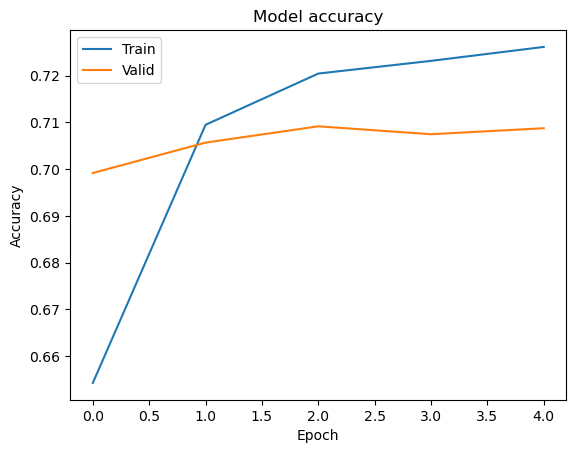

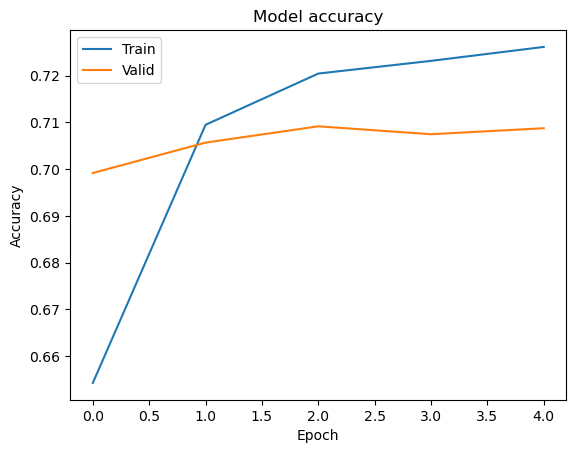

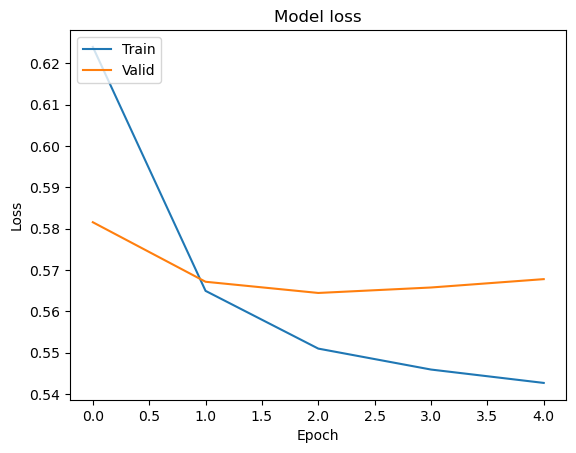

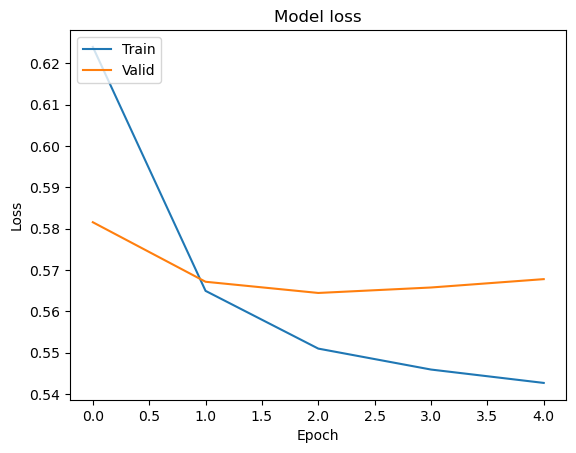

In [38]:
import matplotlib.pyplot as plt
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()    
plot_history(history)

In [39]:
user=25 #user_id
user_df = val_df.reset_index(drop=True).query('user_id==@user')
user_df.head()

,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,label
531,25,195,4,885852008,39,M,engineer,55107,"Terminator, The (1984)",01-Jan-1984,...,0,0,0,0,1,1,0,0,1984,1
2551,25,692,4,885852656,39,M,engineer,55107,"American President, The (1995)",01-Jan-1995,...,0,0,0,1,0,0,0,0,1995,1
8898,25,729,4,885852697,39,M,engineer,55107,Nell (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,1994,1
8940,25,238,4,885852757,39,M,engineer,55107,Raising Arizona (1987),01-Jan-1987,...,0,0,0,0,0,0,0,0,1987,1
8941,25,127,3,885853030,39,M,engineer,55107,"Godfather, The (1972)",01-Jan-1972,...,0,0,0,0,0,0,0,0,1972,0


,user_id,movie_id,rating,timestamp,age,gender,occupation,zip_code,title,release_date,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,label
531,25,195,4,885852008,39,M,engineer,55107,"Terminator, The (1984)",01-Jan-1984,...,0,0,0,0,1,1,0,0,1984,1
2551,25,692,4,885852656,39,M,engineer,55107,"American President, The (1995)",01-Jan-1995,...,0,0,0,1,0,0,0,0,1995,1
8898,25,729,4,885852697,39,M,engineer,55107,Nell (1994),01-Jan-1994,...,0,0,0,0,0,0,0,0,1994,1
8940,25,238,4,885852757,39,M,engineer,55107,Raising Arizona (1987),01-Jan-1987,...,0,0,0,0,0,0,0,0,1987,1
8941,25,127,3,885853030,39,M,engineer,55107,"Godfather, The (1972)",01-Jan-1972,...,0,0,0,0,0,0,0,0,1972,0


In [40]:
user_df.index

Int64Index([  531,  2551,  8898,  8940,  8941,  8973,  9988, 10714, 11263,
            11887, 16970, 17381, 17810, 18971, 19359],
           dtype='int64')

Int64Index([  531,  2551,  8898,  8940,  8941,  8973,  9988, 10714, 11263,
            11887, 16970, 17381, 17810, 18971, 19359],
           dtype='int64')

In [41]:
user_inputs = [pp.transform(val_df)[user_df.index, i] for i in range(feature_num)]
user_df['pred'] = model.predict(user_inputs)
user_df = user_df.sort_values('pred', ascending=False)

1/1 [==============================] - 3s 3s/step


In [42]:
user_df[['title','rating','pred']].head(50)

,title,rating,pred
16970,Vertigo (1958),5,0.985869
11887,"Wrong Trousers, The (1993)",5,0.981165
10714,Citizen Kane (1941),4,0.963085
19359,Raiders of the Lost Ark (1981),5,0.958529
8941,"Godfather, The (1972)",3,0.955515
9988,Duck Soup (1933),4,0.935407
11263,Gandhi (1982),4,0.925312
8973,"Full Monty, The (1997)",4,0.904575
531,"Terminator, The (1984)",4,0.902965
8940,Raising Arizona (1987),4,0.889888


,title,rating,pred
16970,Vertigo (1958),5,0.985869
11887,"Wrong Trousers, The (1993)",5,0.981165
10714,Citizen Kane (1941),4,0.963085
19359,Raiders of the Lost Ark (1981),5,0.958529
8941,"Godfather, The (1972)",3,0.955515
9988,Duck Soup (1933),4,0.935407
11263,Gandhi (1982),4,0.925312
8973,"Full Monty, The (1997)",4,0.904575
531,"Terminator, The (1984)",4,0.902965
8940,Raising Arizona (1987),4,0.889888
